In [1]:
import librosa
from librosa import feature
import numpy as np

In [2]:
x, sr=librosa.load("audio_files/Actor_01/03-01-02-02-01-01-01.wav")

In [3]:
print(x.shape, sr)

(81667,) 22050


In [9]:
x[0: 20000]

array([-3.6192148e-07, -1.4590451e-05, -5.3999561e-06, ...,
       -2.5906095e-06,  1.7739675e-06, -1.8972806e-06], dtype=float32)

In [4]:
nonMuteSections = librosa.effects.split(x)  # split audio with any audio signal lesser than 20db as mute
nonMuteSections

array([[    0, 81667]])

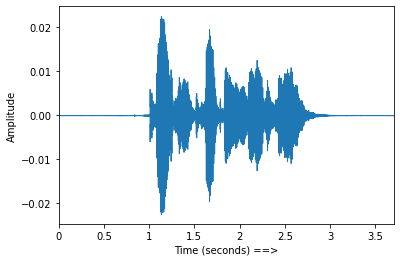

In [5]:
from librosa import display
import matplotlib.pyplot as plt
plt.figure()
librosa.display.waveplot(y=x, sr=sr)
plt.xlabel("Time (seconds) ==>")
plt.ylabel("Amplitude")
plt.show()

In [35]:
from pydub import AudioSegment
t1 = int(nonMuteSections[0][0]/sr * 1000) #Works in milliseconds
t2 = int(nonMuteSections[0][1]/sr * 1000)
newAudio = AudioSegment.from_wav("audio_files/Actor_01/03-01-02-02-01-01-01.wav")
newAudio = newAudio[t1:t2]

In [36]:
newAudio

FileNotFoundError: [WinError 2] The system cannot find the file specified

In [5]:
from pydub import AudioSegment
from pydub.silence import split_on_silence
 
sound_file = AudioSegment.from_wav("./audio_files/Actor_01/03-01-01-01-01-01-01.wav")
audio_chunks = split_on_silence(sound_file, min_silence_len=100, silence_thresh=10 )

In [8]:
sound_file

PermissionError: [WinError 5] Access is denied

In [7]:
AudioSegment.converter = "./venv/Lib/site-packages/ffmpeg"

In [9]:
x

NameError: name 'x' is not defined